In [2]:
!nvidia-smi

Wed Aug 30 04:39:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    30W /  70W |   5100MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# 데이터 로딩 및 전처리
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# 클래스 이름 정의
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
# BasicBlock 정의
def BasicBlock(inputs, filters, stride=1):
    shortcut = inputs

    x = Conv2D(filters, (3, 3), strides=stride, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if stride != 1:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    x = Dropout(0.8)(x) # Dropout = 0.8
    
    return x

# ResNet 정의
def ResNet18():
    inputs = Input(shape=(32, 32, 3))

    x = Conv2D(64, (3, 3), strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = BasicBlock(x, 64)
    x = BasicBlock(x, 64)
    x = BasicBlock(x, 128, stride=2)
    x = BasicBlock(x, 128)
    x = BasicBlock(x, 256, stride=2)
    x = BasicBlock(x, 256)
    x = BasicBlock(x, 512, stride=2)
    x = BasicBlock(x, 512)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

In [5]:
model = ResNet18()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [6]:
# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [7]:
# 학습 루프, Dropout = 0.8
history = model.fit(x_train, y_train, batch_size=128, epochs=100)
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

Epoch 1/100
391/391 [==============================] - 52s 118ms/step - loss: 2.3588 - accuracy: 0.1920
Epoch 2/100
391/391 [==============================] - 45s 116ms/step - loss: 1.9542 - accuracy: 0.2522
Epoch 3/100
391/391 [==============================] - 45s 116ms/step - loss: 1.8097 - accuracy: 0.3099
Epoch 4/100
391/391 [==============================] - 45s 116ms/step - loss: 1.6882 - accuracy: 0.3565
Epoch 5/100
391/391 [==============================] - 45s 116ms/step - loss: 1.5956 - accuracy: 0.3982
Epoch 6/100
391/391 [==============================] - 45s 116ms/step - loss: 1.4791 - accuracy: 0.4453
Epoch 7/100
391/391 [==============================] - 45s 116ms/step - loss: 1.3748 - accuracy: 0.4899
Epoch 8/100
391/391 [==============================] - 45s 116ms/step - loss: 1.2879 - accuracy: 0.5229
Epoch 9/100
391/391 [==============================] - 45s 116ms/step - loss: 1.2220 - accuracy: 0.5489
Epoch 10/100
391/391 [==============================] - 45s 116m

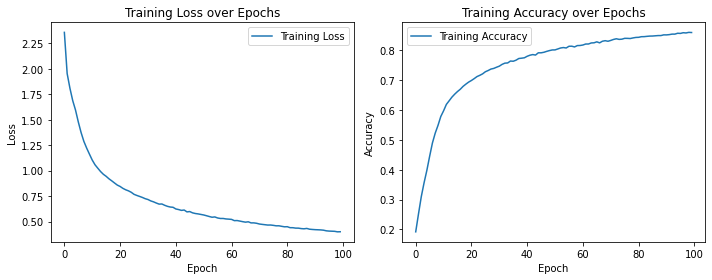

In [8]:
# 학습 결과 시각화
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

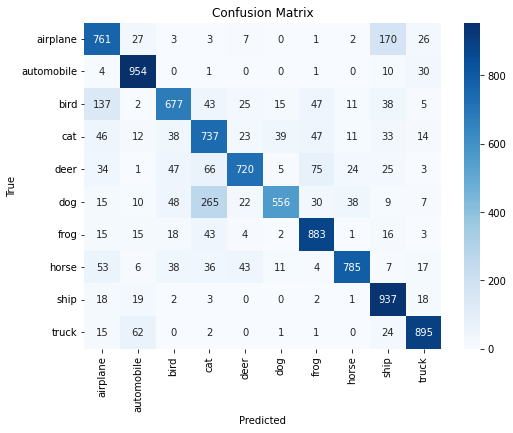

In [9]:
# 컨퓨전 매트릭스 생성
y_pred = model.predict(x_test)
y_pred_classes = tf.argmax(y_pred, axis=1)
confusion_mtx = confusion_matrix(y_test, y_pred_classes)

# 컨퓨전 매트릭스 시각화
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


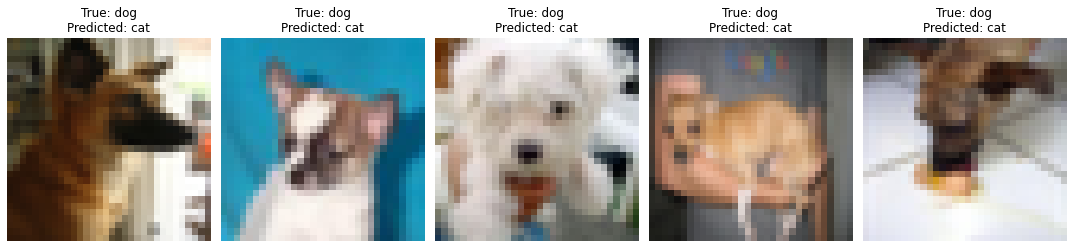

In [11]:
# 모델이 "고양이(cat)"로 예측한 인덱스 찾기
misclassified_as_cat_idx = np.where(y_pred_classes == 3)[0]

# 실제 값이 "개(dog)"인 인덱스만 필터링
misclassified_dog_as_cat_idx = [idx for idx in misclassified_as_cat_idx if y_test[idx] == 5]

# 랜덤하게 5개의 인덱스 선택
random_misclassified_idx = np.random.choice(misclassified_dog_as_cat_idx, 5, replace=False)

# 랜덤으로 선택한 오분류된 이미지 시각화
plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_misclassified_idx):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_test[idx].reshape(32, 32, 3), cmap='gray')
    true_label = class_names[y_test[idx][0]]
    predicted_label = class_names[y_pred_classes[idx]]
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()